**Approach 1:\
Travel Destination Recommendation System:**

23565002: Aditya Raj\
23565005: Maharshi Gohil\
23566014: Shubham Kumar\
23566021: Anurag Ramteke

In [88]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import process

# Load the dataset
travel_data = pd.read_csv('Top Indian Places to Visit.csv')

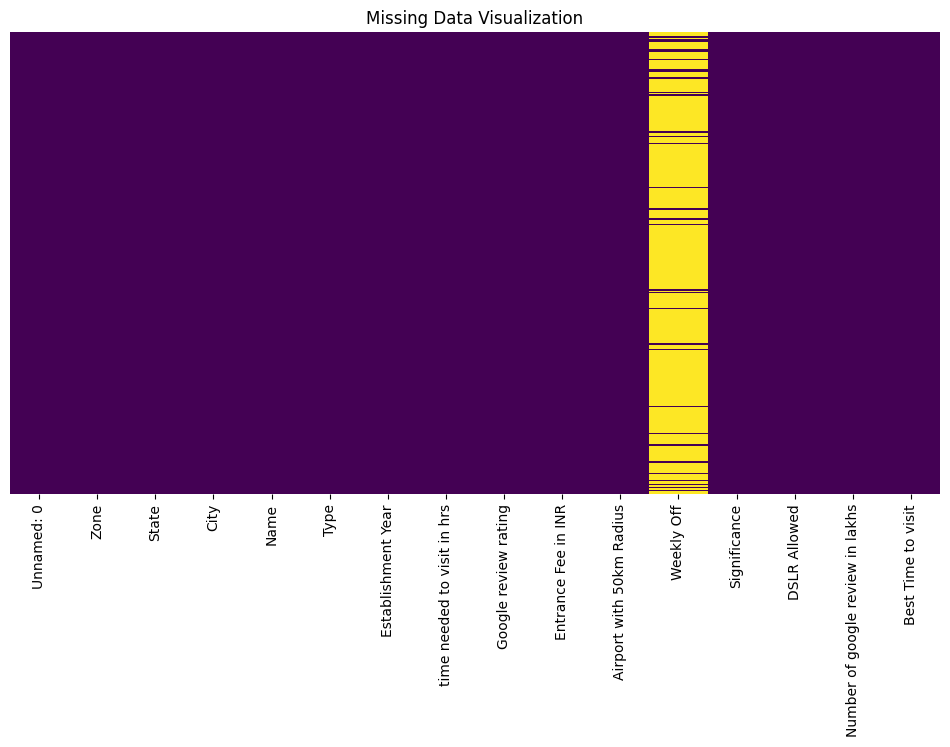

In [89]:
plt.figure(figsize=(12, 6))
sns.heatmap(travel_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Missing Data Visualization')
plt.show()

In [90]:
# Drop unnecessary columns
travel_data.drop('Unnamed: 0', axis=1, inplace=True)

# Handle missing values in 'Weekly Off' column
travel_data['Weekly Off'].fillna('NAN', inplace=True) # from the graph above we found column with missing value

In [91]:
print(travel_data.head())

       Zone  State   City                  Name          Type  \
0  Northern  Delhi  Delhi            India Gate  War Memorial   
1  Northern  Delhi  Delhi        Humayun's Tomb          Tomb   
2  Northern  Delhi  Delhi     Akshardham Temple        Temple   
3  Northern  Delhi  Delhi  Waste to Wonder Park    Theme Park   
4  Northern  Delhi  Delhi         Jantar Mantar   Observatory   

  Establishment Year  time needed to visit in hrs  Google review rating  \
0               1921                          0.5                   4.6   
1               1572                          2.0                   4.5   
2               2005                          5.0                   4.6   
3               2019                          2.0                   4.1   
4               1724                          2.0                   4.2   

   Entrance Fee in INR Airport with 50km Radius Weekly Off   Significance  \
0                    0                      Yes        NAN     Historical   
1   

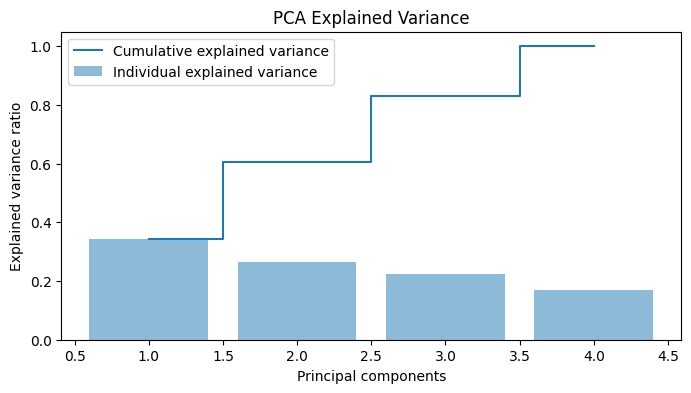

In [92]:
# Handling missing values for numerical analysis
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(travel_data.select_dtypes(include=[np.number]))

# Standardizing the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_imputed)

# Applying PCA
pca = PCA()
pca.fit(data_scaled)
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 4))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.title('PCA Explained Variance')
plt.show()

To capture over 80% of the variance in our dataset, we need at least four features. The PCA analysis shows that using just two features isn't enough as they don’t hold sufficient information on their own.

In [93]:
# Preprocess text data for content-based filtering
def preprocess_text(text):
    return ' '.join(str(text).lower().split())

text_columns = ['State', 'City', 'Type', 'Significance', 'Best Time to visit']
for col in text_columns:
    travel_data[col] = travel_data[col].apply(preprocess_text)

# Content-Based Filtering

Create TF-IDF vectorizer.\
Compute pairwise cosine similarity for text features.

In [94]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the text data:
# This applies the TF-IDF transformation to the combined text from specified columns for each row.
# The lambda function joins the text from all the specified text columns into a single string per row,
# which the vectorizer then processes.
text_features = tfidf_vectorizer.fit_transform(travel_data[text_columns].apply(lambda x: ' '.join(x), axis=1))

# Compute pairwise cosine similarity for the TF-IDF vectors
# This computes the cosine similarity between every pair of travel destinations
# based on their TF-IDF feature vectors. The result is a square matrix where
# each element [i, j] represents the cosine similarity score between the ith and jth entry in the dataset.
cosine_sim = cosine_similarity(text_features, text_features)

print(cosine_sim)

[[1.         0.54283853 0.57756928 ... 0.         0.06259602 0.06341388]
 [0.54283853 1.         0.71145573 ... 0.         0.06678839 0.06766103]
 [0.57756928 0.71145573 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.2675338 ]
 [0.06259602 0.06678839 0.         ... 0.         1.         0.67873606]
 [0.06341388 0.06766103 0.         ... 0.2675338  0.67873606 1.        ]]


# Collaborative Filtering

Preprocess and scale features.\
Reduce dimensionality using Truncated SVD.\
Fit Nearest Neighbors model.

In [95]:
# Define the list of numerical features that will be used in the collaborative filtering model
collab_features = ['time needed to visit in hrs', 'Google review rating', 'Entrance Fee in INR', 'Number of google review in lakhs']

imputer = SimpleImputer(strategy='mean') # fill missing values with the mean of each column
scaler = StandardScaler()
collab_preprocessor = make_pipeline(imputer, scaler) ## Combine the imputer and scaler into a single pipeline for sequential data transformation
collab_data = collab_preprocessor.fit_transform(travel_data[collab_features])

In [96]:
# Create a TruncatedSVD object for dimensionality reduction, specifying to reduce the features down to 4 dimensions
svd = TruncatedSVD(n_components=4)
collab_pipeline = make_pipeline(collab_preprocessor, svd) # Combine the preprocessing pipeline with SVD into a new pipeline
collab_features_reduced = collab_pipeline.fit_transform(travel_data[collab_features])

The KNN algorithm is utilized here to efficiently find the nearest travel destinations based on cosine similarity.\
By identifying the closest neighbors to a given destination, KNN helps in recommending similar destinations to users. This is based on a similarity measure that considers several key attributes of the destinations, such as the time needed to visit, review ratings, entrance fees, and popularity.

In [97]:
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(collab_features_reduced)

print(collab_features_reduced)

[[-1.33099228  2.77688971 -1.93098448  0.58944978]
 [ 0.01948555 -0.03946035 -0.016387   -0.25697872]
 [ 2.00037741  0.25814808  0.4178044  -2.60271205]
 ...
 [-0.31607771 -0.01338049  0.69204908 -0.5184372 ]
 [ 0.36264605  0.04038997 -0.22829181  0.05269562]
 [ 0.19466343  0.36266261 -0.0947719  -0.08027639]]


# Hybrid Recommendation

Define functions to get recommendations based on content-based and collaborative filtering.\
Combine recommendations from both approaches.

In [98]:
pip install fuzzywuzzy

In [99]:
# Function to get collaborative recommendations using KNN
def get_collab_recommendations(idx, k=5):
    distances, indices = knn.kneighbors([collab_features_reduced[idx]], n_neighbors=k+1)
    return indices.flatten()[1:]

In [100]:
# Function to get hybrid recommendations combining content-based and collaborative filtering
def get_hybrid_recommendations(name, k=20):
    idx = travel_data[travel_data['Name'] == name].index[0]
    content_indices = pd.Series(cosine_sim[idx]).nlargest(k).index # Get the top k similar destinations using content-based similarity (cosine similarity)
    collab_indices = get_collab_recommendations(idx, k) # Get the collaborative filtering recommendations
    hybrid_indices = list(set(content_indices) | set(collab_indices))
    hybrid_indices = hybrid_indices[:k]  # Take only the first k unique recommendations
    return travel_data.iloc[hybrid_indices] # Return the actual destination entries from the dataset

In [101]:
# Function to display recommendations
def display_recommendations(recommendations):
    print("Top Attractions Recommendations:")
    print("-" * 70)
    print("{:<5} {:<30} {:<20} {:<20} {:<15} {:<15}".format("Rank", "Name", "State", "City", "Type", "Google Review Rating"))
    print("-" * 70)
    for i, (_, attraction) in enumerate(recommendations.iterrows(), 1):
        print("{:<5} {:<30} {:<20} {:<20} {:<15} {:<15}".format(i, attraction['Name'], attraction['State'], attraction['City'], attraction['Type'], attraction['Google review rating']))

In [102]:
# Function to allow the user to select a destination based on the state
def select_destination_by_state(state):
    state_destinations = travel_data[travel_data['State'].str.lower() == state.lower()]
    if state_destinations.empty:
        print("No attractions found for the specified state.")
        return None
    else:
        print("Attractions in {}:".format(state))
        print(state_destinations[['Name', 'City']])
        selected_destination = input("Enter the name of the destination(Case Insensitive): ").strip()
        return selected_destination

In [103]:
# Function to recommend top 20 attractions based on the selected destination
def recommend_top_attractions(selected_destination):
    if selected_destination is None:
        return
    recommendations = get_hybrid_recommendations(selected_destination, k=20)
    if recommendations.empty:
        print("Attraction not found in the dataset.")
    else:
        display_recommendations(recommendations)

In [104]:
print("Please enter a state and then enter a destination from the list which you have visited or you familiar with.")
state = input("Enter the name of the state: ")
selected_destination = select_destination_by_state(state)
recommend_top_attractions(selected_destination)

Please enter a state and then enter a destination from the list which you have visited or you familiar with.
Enter the name of the state: Uttarakhand
Attractions in Uttarakhand:
                          Name         City
168                 Naini Lake     nainital
169               Laxman Jhula    rishikesh
170               Har Ki Pauri     haridwar
171              Robber's Cave     dehradun
172               Kempty Falls    mussoorie
173            Auli Ski Resort         auli
174           Badrinath Temple    badrinath
175  Binsar Wildlife Sanctuary       almora
176          Chaubatia Gardens     ranikhet
177  Jim Corbett National Park  jim corbett
178            Gangotri Temple   uttarkashi
179            Tungnath Temple       chopta
180          Valley of Flowers    joshimath
306                  Kedarnath    kedarnath
Enter the name of the destination(Case Insensitive): Naini Lake
Top Attractions Recommendations:
-----------------------------------------------------------------

In [105]:
# Function to select destination and recommend places within a state (using hybrid approach)
def recommend_places_within_state(state, k=20):
    # Filter the dataset for attractions in the specified state
    state_data = travel_data[travel_data['State'].str.lower() == state.lower()]

    # Check if there are sufficient attractions to recommend
    if state_data.empty:
        print("No attractions found in the specified state.")
        return

    # Sort by Google review ratings if available
    state_data_sorted = state_data.sort_values(by='Google review rating', ascending=False).head(k)

    # Display top attractions in the state
    display_recommendations(state_data_sorted)

In [106]:
state = input("Enter the name of the state you want to explore: ").strip()
recommend_places_within_state(state)

Enter the name of the state you want to explore: Gujarat
Top Attractions Recommendations:
----------------------------------------------------------------------
Rank  Name                           State                City                 Type            Google Review Rating
----------------------------------------------------------------------
1     Rann Utsav                     gujarat              rann of kutch        cultural        4.9            
2     Somnath Temple                 gujarat              somnath              temple          4.8            
3     Dwarkadhish Temple             gujarat              dwarka               temple          4.7            
4     Sabarmati Ashram               gujarat              ahmedabad            historical      4.6            
5     White Desert                   gujarat              bhuj                 site            4.6            
6     Statue of Unity                gujarat              kevadia              monument        4.